In [ ]:
# download photons dataset
!echo "Downloading datasets..."
!curl -L -o photons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

# download electrons dataset
!curl -L -o electrons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!echo "Downloads complete."

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import h5py
import matplotlib.pyplot as plt
import random
import os
import time
from torch.amp import autocast, GradScaler

# --- Configuration ---
PHOTON_FILE = 'photons.hdf5'
ELECTRON_FILE = 'electrons.hdf5'
MODEL_SAVE_PATH = 'electron_photon_resnet15.pth'
OPTIMIZER_SAVE_PATH = MODEL_SAVE_PATH + ".opt"

# --- Hyperparameters ---
SEED = 42
BATCH_SIZE = 512
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 30 # Increased epochs
NUM_WORKERS = 4 
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2

# --- Feature Flags ---
USE_LOG_TRANSFORM = True # Apply log(1+E) on GPU
USE_AUGMENTATION = True # Apply light augmentations on GPU
USE_MIXED_PRECISION = torch.cuda.is_available()

# --- Reproducibility ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # torch.backends.cudnn.deterministic = True # Can uncomment for stricter reproducibility
    # torch.backends.cudnn.benchmark = False   # Usually set False if deterministic is True

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Mixed Precision Training Enabled: {USE_MIXED_PRECISION}")

# --- File Checks ---
if not os.path.exists(PHOTON_FILE): raise FileNotFoundError(f"Photon file not found: {PHOTON_FILE}")
if not os.path.exists(ELECTRON_FILE): raise FileNotFoundError(f"Electron file not found: {ELECTRON_FILE}")

Using device: cuda
Mixed Precision Training Enabled: True


In [2]:
with h5py.File(PHOTON_FILE, 'r') as f:
    photon_X_shape = f['X'].shape; photon_y_shape = f['y'].shape
    photon_X_dtype = f['X'].dtype; photon_y_dtype = f['X'].dtype
    photon_y_sample = f['y'][:10]; num_photons = len(f['y'])
    
    print(f"Photon X shape: {photon_X_shape}, dtype: {photon_X_dtype}")
    print(f"Photon y shape: {photon_y_shape}, dtype: {photon_y_dtype}")
    print(f"Photon y sample: {photon_y_sample}")
    print(f"Number of photons: {num_photons}")

with h5py.File(ELECTRON_FILE, 'r') as f:
    electron_X_shape = f['X'].shape; electron_y_shape = f['y'].shape
    electron_X_dtype = f['X'].dtype; electron_y_dtype = f['X'].dtype
    electron_y_sample = f['y'][:10]; num_electrons = len(f['y'])
    
    print(f"Electron X shape: {electron_X_shape}, dtype: {electron_X_dtype}")
    print(f"Electron y shape: {electron_y_shape}, dtype: {electron_y_dtype}")
    print(f"Electron y sample: {electron_y_sample}")
    print(f"Number of electrons: {num_electrons}")

total_samples = num_photons + num_electrons
print(f"Total samples: {total_samples}")
print(f"Class Balance: Photons={num_photons}, Electrons={num_electrons}")

# determined from inspection
PHOTON_LABEL = 0.0
ELECTRON_LABEL = 1.0
print(f"Labels: Photon = {PHOTON_LABEL}, Electron = {ELECTRON_LABEL}")

Photon X shape: (249000, 32, 32, 2), dtype: float32
Photon y shape: (249000,), dtype: float32
Photon y sample: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Number of photons: 249000
Electron X shape: (249000, 32, 32, 2), dtype: float32
Electron y shape: (249000,), dtype: float32
Electron y sample: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of electrons: 249000
Total samples: 498000
Class Balance: Photons=249000, Electrons=249000
Labels: Photon = 0.0, Electron = 1.0


Plotting sample images...


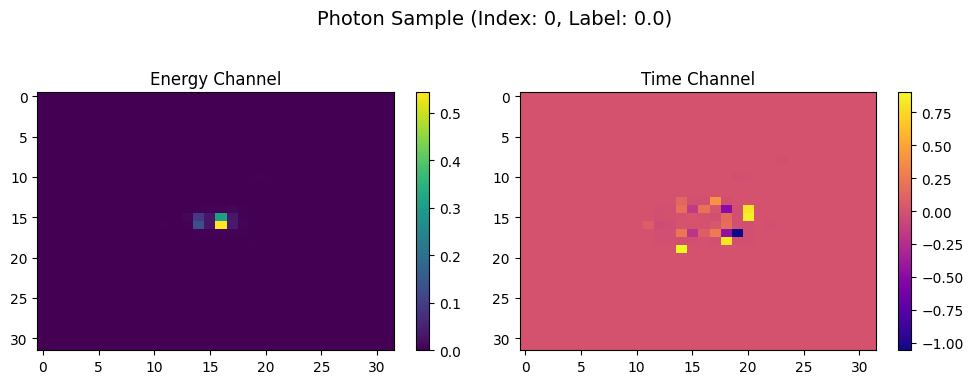

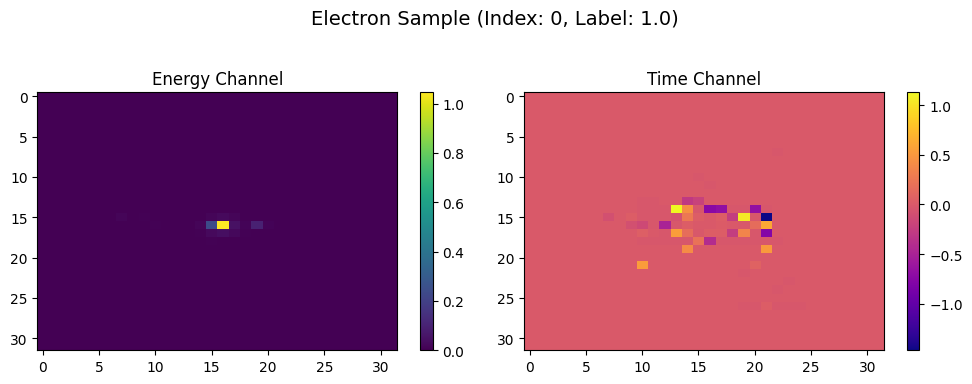


Plotting histograms using 50000 samples per class (GPU processing)...
Histogram data preparation took 174.17 seconds.


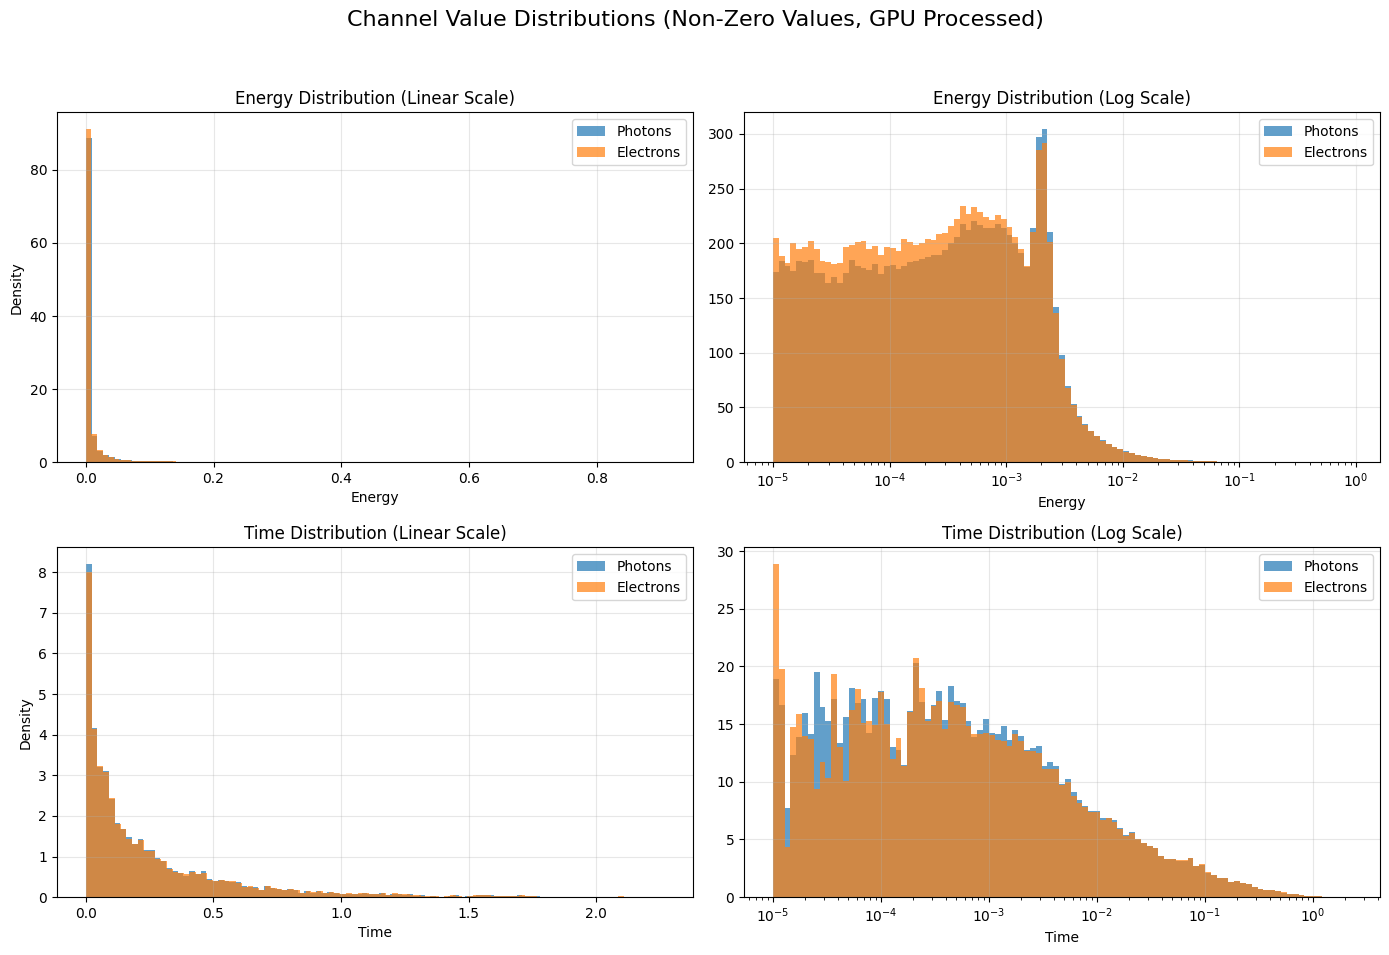

In [6]:
def plot_sample(file_path, index, particle_type_str):
    """Plots Energy and Time channels for a single sample."""
    with h5py.File(file_path, 'r') as f:
        img = f['X'][index] # expected: (32, 32, 2)
        label_val = f['y'][index]

    energy, time = img[:, :, 0], img[:, :, 1]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"{particle_type_str} Sample (Index: {index}, Label: {label_val})", fontsize=14)

    im_energy = axes[0].imshow(energy, cmap='viridis', aspect='auto')
    axes[0].set_title('Energy Channel')
    fig.colorbar(im_energy, ax=axes[0])

    im_time = axes[1].imshow(time, cmap='plasma', aspect='auto')
    axes[1].set_title('Time Channel')
    fig.colorbar(im_time, ax=axes[1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # adjust layout to prevent title overlap
    plt.show()

def plot_channel_histograms_gpu(num_samples_hist=50000, batch_size_hist=10000):
    """Plots histograms using GPU acceleration after batch-loading."""
    print(f"\nPlotting histograms using {num_samples_hist} samples per class (GPU processing)...")
    start_time = time.time()

    photon_indices = np.random.choice(num_photons, num_samples_hist, replace=False)
    electron_indices = np.random.choice(num_electrons, num_samples_hist, replace=False)

    all_photon_energies_gpu = []
    all_photon_times_gpu = []
    all_electron_energies_gpu = []
    all_electron_times_gpu = []

    # --- Process Photons ---
    with h5py.File(PHOTON_FILE, 'r') as f_p:
        photon_X_ds = f_p['X']
        for i in range(0, num_samples_hist, batch_size_hist):
            batch_indices = np.sort(photon_indices[i : i + batch_size_hist])
            if len(batch_indices) == 0: continue
            img_batch_np = photon_X_ds[batch_indices, :, :, :].astype(np.float32)
            img_batch_gpu = torch.from_numpy(img_batch_np).to(device) # Move to GPU

            energy_gpu = img_batch_gpu[:, :, :, 0]
            time_gpu = img_batch_gpu[:, :, :, 1]

            # Apply log transform on GPU if enabled
            if USE_LOG_TRANSFORM:
                 energy_gpu = torch.log1p(energy_gpu)

            all_photon_energies_gpu.append(energy_gpu.flatten())
            all_photon_times_gpu.append(time_gpu.flatten())
            del img_batch_gpu, energy_gpu, time_gpu # Free GPU memory
            torch.cuda.empty_cache()

    # --- Process Electrons ---
    with h5py.File(ELECTRON_FILE, 'r') as f_e:
        electron_X_ds = f_e['X']
        for i in range(0, num_samples_hist, batch_size_hist):
            batch_indices = np.sort(electron_indices[i : i + batch_size_hist])
            if len(batch_indices) == 0: continue
            img_batch_np = electron_X_ds[batch_indices, :, :, :].astype(np.float32)
            img_batch_gpu = torch.from_numpy(img_batch_np).to(device) # Move to GPU

            energy_gpu = img_batch_gpu[:, :, :, 0]
            time_gpu = img_batch_gpu[:, :, :, 1]

            if USE_LOG_TRANSFORM:
                 energy_gpu = torch.log1p(energy_gpu) # Log on GPU

            all_electron_energies_gpu.append(energy_gpu.flatten())
            all_electron_times_gpu.append(time_gpu.flatten())
            del img_batch_gpu, energy_gpu, time_gpu
            torch.cuda.empty_cache()


    # Concatenate results on GPU, then move to CPU for plotting
    photon_energies = torch.cat(all_photon_energies_gpu).cpu().numpy()
    photon_times = torch.cat(all_photon_times_gpu).cpu().numpy()
    electron_energies = torch.cat(all_electron_energies_gpu).cpu().numpy()
    electron_times = torch.cat(all_electron_times_gpu).cpu().numpy()

    del all_photon_energies_gpu, all_photon_times_gpu, all_electron_energies_gpu, all_electron_times_gpu
    torch.cuda.empty_cache()

    # Filter non-zero for plotting
    photon_energies_nz = photon_energies[photon_energies > 1e-6]
    electron_energies_nz = electron_energies[electron_energies > 1e-6]
    photon_times_nz = photon_times[photon_times > 1e-6] # Assuming time shouldn't be negative/zero
    electron_times_nz = electron_times[electron_times > 1e-6]

    print(f"Histogram data preparation took {time.time() - start_time:.2f} seconds.")

    # --- Plotting (same as before) ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Channel Value Distributions (Non-Zero Values, GPU Processed)", fontsize=16)
    # (Plotting code remains the same as your cell 4, using *_nz variables - omitted for brevity)
    axes[0, 0].hist(photon_energies_nz, bins=100, alpha=0.7, label='Photons', density=True); axes[0, 0].hist(electron_energies_nz, bins=100, alpha=0.7, label='Electrons', density=True); axes[0, 0].set_title('Energy Distribution (Linear Scale)'); axes[0, 0].set_xlabel('Energy'); axes[0, 0].set_ylabel('Density'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)
    min_energy = min(photon_energies_nz.min(), electron_energies_nz.min()) if len(photon_energies_nz)>0 and len(electron_energies_nz)>0 else 1e-3; max_energy = max(photon_energies_nz.max(), electron_energies_nz.max()) if len(photon_energies_nz)>0 and len(electron_energies_nz)>0 else 1.0; log_bins_energy = np.logspace(np.log10(max(1e-5, min_energy)), np.log10(max_energy), 100); axes[0, 1].hist(photon_energies_nz, bins=log_bins_energy, alpha=0.7, label='Photons', density=True); axes[0, 1].hist(electron_energies_nz, bins=log_bins_energy, alpha=0.7, label='Electrons', density=True); axes[0, 1].set_title('Energy Distribution (Log Scale)'); axes[0, 1].set_xlabel('Energy'); axes[0, 1].set_xscale('log'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)
    axes[1, 0].hist(photon_times_nz, bins=100, alpha=0.7, label='Photons', density=True); axes[1, 0].hist(electron_times_nz, bins=100, alpha=0.7, label='Electrons', density=True); axes[1, 0].set_title('Time Distribution (Linear Scale)'); axes[1, 0].set_xlabel('Time'); axes[1, 0].set_ylabel('Density'); axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)
    min_time = min(photon_times_nz.min(), electron_times_nz.min()) if len(photon_times_nz)>0 and len(electron_times_nz)>0 else 1e-3; max_time = max(photon_times_nz.max(), electron_times_nz.max()) if len(photon_times_nz)>0 and len(electron_times_nz)>0 else 1.0; log_bins_time = np.logspace(np.log10(max(1e-5, min_time)), np.log10(max_time), 100); axes[1, 1].hist(photon_times_nz, bins=log_bins_time, alpha=0.7, label='Photons', density=True); axes[1, 1].hist(electron_times_nz, bins=log_bins_time, alpha=0.7, label='Electrons', density=True); axes[1, 1].set_title('Time Distribution (Log Scale)'); axes[1, 1].set_xlabel('Time'); axes[1, 1].set_xscale('log'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


# --- Perform Visualizations ---
print("Plotting sample images...")
plot_sample(PHOTON_FILE, 0, "Photon")
plot_sample(ELECTRON_FILE, 0, "Electron")
plot_channel_histograms_gpu() # Use GPU accelerated version

In [7]:
def compute_stats_gpu(sample_size=50000, batch_size_stats=10000):
    """Computes mean and std dev using GPU acceleration."""
    print(f"\nComputing normalization stats from {sample_size} samples (GPU processing)...")
    start_time = time.time()
    indices = np.random.choice(total_samples, sample_size, replace=False)

    # Use float64 for accumulators on CPU for precision, then move to GPU if needed
    data_sum_gpu = torch.zeros(2, dtype=torch.float64, device=device)
    data_sum_sq_gpu = torch.zeros(2, dtype=torch.float64, device=device)
    num_pixels = sample_size * 32 * 32

    f_p = h5py.File(PHOTON_FILE, 'r')
    f_e = h5py.File(ELECTRON_FILE, 'r')
    photon_X_ds = f_p['X']
    electron_X_ds = f_e['X']

    processed_count = 0
    for i in range(0, sample_size, batch_size_stats):
        batch_indices_global = indices[i : i + batch_size_stats]
        current_batch_size = len(batch_indices_global)
        if current_batch_size == 0: continue

        photon_mask = batch_indices_global < num_photons
        electron_mask = ~photon_mask
        photon_indices_batch = batch_indices_global[photon_mask]
        electron_indices_batch = batch_indices_global[electron_mask] - num_photons

        batch_data_list = []
        if len(photon_indices_batch) > 0: batch_data_list.append(photon_X_ds[np.sort(photon_indices_batch), :, :, :])
        if len(electron_indices_batch) > 0: batch_data_list.append(electron_X_ds[np.sort(electron_indices_batch), :, :, :])
        if not batch_data_list: continue

        img_batch_np = np.concatenate(batch_data_list, axis=0).astype(np.float32)
        img_batch_gpu = torch.from_numpy(img_batch_np).to(device, dtype=torch.float64) # Use float64 on GPU

        # Apply log transform on GPU if enabled
        if USE_LOG_TRANSFORM:
             # Operate on channels correctly: img_batch_gpu is (B, H, W, C) -> (B, H, W, 0) is energy
             img_batch_gpu[:, :, :, 0] = torch.log1p(img_batch_gpu[:, :, :, 0])

        # Sum over Batch, H, W dimensions. Keep Channel dimension.
        data_sum_gpu += torch.sum(img_batch_gpu, dim=(0, 1, 2))
        data_sum_sq_gpu += torch.sum(img_batch_gpu**2, dim=(0, 1, 2))

        processed_count += current_batch_size
        if processed_count % (10 * batch_size_stats) == 0 or processed_count >= sample_size:
             print(f"  Processed {processed_count}/{sample_size} samples for stats...")
        del img_batch_gpu # Free GPU memory

    f_p.close(); f_e.close()

    mean_gpu = data_sum_gpu / num_pixels
    variance_gpu = (data_sum_sq_gpu / num_pixels) - (mean_gpu**2)
    std_dev_gpu = torch.sqrt(torch.clamp(variance_gpu, min=1e-12)) # Clamp variance before sqrt
    std_dev_gpu = torch.clamp(std_dev_gpu, min=1e-6) # Floor std dev

    # Move stats back to CPU, convert to float32
    mean_cpu = mean_gpu.cpu().numpy().astype(np.float32)
    std_dev_cpu = std_dev_gpu.cpu().numpy().astype(np.float32)

    del data_sum_gpu, data_sum_sq_gpu, mean_gpu, variance_gpu, std_dev_gpu
    torch.cuda.empty_cache()

    print(f"Stats computation took {time.time() - start_time:.2f} seconds.")
    print(f"Computed Mean: {mean_cpu}")
    print(f"Computed Std Dev: {std_dev_cpu}")
    return mean_cpu, std_dev_cpu

# Compute stats globally once using the GPU accelerated function
GLOBAL_MEAN, GLOBAL_STD = compute_stats_gpu()
# Convert stats to tensors on the correct device for use in the training loop
GLOBAL_MEAN_GPU = torch.from_numpy(GLOBAL_MEAN).to(device)
GLOBAL_STD_GPU = torch.from_numpy(GLOBAL_STD).to(device)


class ParticleDataset(Dataset):
    """
    Optimized Dataset: Reads raw data from HDF5 and converts to tensor.
    Preprocessing (log, norm, augment) is deferred to the GPU during training.
    Uses persistent file handles per worker.
    """
    def __init__(self, photon_file, electron_file, indices, num_photons_total):
        self.photon_path = photon_file
        self.electron_path = electron_file
        self.indices = indices # Indices for this specific subset (train/val/test)
        self.num_photons = num_photons_total # Pass total photon count

        # Worker-specific state
        self._photon_file_handle = None
        self._electron_file_handle = None
        self._worker_pid = None

    def _get_file_handle(self, file_path, is_photon):
        current_pid = os.getpid()
        handle_attr = '_photon_file_handle' if is_photon else '_electron_file_handle'
        stored_handle = getattr(self, handle_attr)
        if current_pid != self._worker_pid or stored_handle is None:
            # print(f"Worker {current_pid}: Opening {file_path}") # Debug
            if stored_handle:
                 try: stored_handle.close()
                 except: pass # Ignore errors during close
            stored_handle = h5py.File(file_path, 'r')
            setattr(self, handle_attr, stored_handle)
            self._worker_pid = current_pid
        return stored_handle

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        global_idx = self.indices[idx]
        try:
            if global_idx < self.num_photons:
                f = self._get_file_handle(self.photon_path, is_photon=True)
                internal_idx = global_idx
                label = PHOTON_LABEL
            else:
                f = self._get_file_handle(self.electron_path, is_photon=False)
                internal_idx = global_idx - self.num_photons
                label = ELECTRON_LABEL

            # Read raw data, transpose C to last dim -> (H, W, C) expected by later steps
            x_raw = f['X'][internal_idx].astype(np.float32) # Shape (32, 32, 2)

            # Convert to tensor - DEFER ALL OTHER PREPROCESSING
            # Keep as float32 for now, mixed precision handles conversion later
            x_tensor = torch.from_numpy(x_raw)
            y_tensor = torch.tensor([label], dtype=torch.float32)

            return x_tensor, y_tensor

        except Exception as e:
             print(f"ERROR in worker {os.getpid()} loading index {idx} (Global: {global_idx}): {e}")
             return torch.zeros((32, 32, 2), dtype=torch.float32), torch.tensor([-1.0], dtype=torch.float32) # Return in (H,W,C)

    def __del__(self):
        # Close handles when dataset object is deleted (best effort)
        if hasattr(self, '_photon_file_handle') and self._photon_file_handle:
            try: self._photon_file_handle.close()
            except: pass
        if hasattr(self, '_electron_file_handle') and self._electron_file_handle:
            try: self._electron_file_handle.close()
            except: pass


Computing normalization stats from 50000 samples (GPU processing)...
  Processed 50000/50000 samples for stats...
Stats computation took 92.06 seconds.
Computed Mean: [ 0.00102398 -0.00024885]
Computed Std Dev: [0.01808449 0.06731523]


In [8]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False); self.bn1 = nn.BatchNorm2d(planes); self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False); self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample; self.stride = stride
    def forward(self, x):
        identity = x; out = self.conv1(x); out = self.bn1(out); out = self.relu(out); out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None: identity = self.downsample(x)
        out += identity; out = self.relu(out); return out

class ResNet15(nn.Module):
    def __init__(self, block=BasicBlock, layers=[3, 2, 2], num_classes=1, in_channels=2, dropout_prob=0.3):
        super(ResNet15, self).__init__()
        self.in_planes = 64
        # Input: (B, C, H, W) = (B, 2, 32, 32)
        self.conv1 = nn.Conv2d(in_channels, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False) # Output: (B, 64, 32, 32)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        # No MaxPool

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1) # Output: (B, 64, 32, 32)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # Output: (B, 128, 16, 16)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) # Output: (B, 256, 8, 8)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Output: (B, 256, 1, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(256 * block.expansion, num_classes) # Output: (B, 1)

        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)): nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []; layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks): layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Expects input x: (B, C, H, W)
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        # Return raw logits
        return x

# Instantiate the model
model = ResNet15().to(device)
print(f"Model Architecture:\n{model}")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}"); print(f"Trainable Parameters: {trainable_params:,}")

Model Architecture:
ResNet15(
  (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [9]:
indices = np.arange(total_samples); np.random.shuffle(indices)
test_split_idx = int(np.floor(TEST_SPLIT * total_samples)); val_split_idx = int(np.floor((VAL_SPLIT + TEST_SPLIT) * total_samples))
test_indices = indices[:test_split_idx]; val_indices = indices[test_split_idx:val_split_idx]; train_indices = indices[val_split_idx:]
print(f"\nDataset Split:"); print(f"  Training: {len(train_indices)} samples"); print(f"  Validation: {len(val_indices)} samples"); print(f"  Test: {len(test_indices)} samples")

# --- Create Datasets ---
# Pass only necessary info to Dataset, handle preprocessing in training loop
train_dataset = ParticleDataset(PHOTON_FILE, ELECTRON_FILE, train_indices, num_photons)
val_dataset = ParticleDataset(PHOTON_FILE, ELECTRON_FILE, val_indices, num_photons)
test_dataset = ParticleDataset(PHOTON_FILE, ELECTRON_FILE, test_indices, num_photons)

# --- Create DataLoaders ---
pin_memory = device.type == 'cuda'
persist_workers = NUM_WORKERS > 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persist_workers, drop_last=True) # drop_last=True can sometimes help with stability/speed if last batch is small
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persist_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persist_workers)
print(f"\nDataLoaders created: Batch Size={BATCH_SIZE}, Num Workers={NUM_WORKERS}, Persistent={persist_workers}")

# --- Loss, Optimizer, Scheduler ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True) # Increased factor slightly

# --- Mixed Precision Scaler ---
scaler = GradScaler(enabled=USE_MIXED_PRECISION)

# --- Load Checkpoint Logic ---
# (Same as your cell 7 - checking for MODEL_SAVE_PATH and OPTIMIZER_SAVE_PATH)
start_epoch = 0
if os.path.exists(MODEL_SAVE_PATH):
    print(f"\nLoading model weights from {MODEL_SAVE_PATH}...")
    try:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print("Model weights loaded.")
        if os.path.exists(OPTIMIZER_SAVE_PATH):
             print(f"Loading optimizer/scheduler state from {OPTIMIZER_SAVE_PATH}...")
             checkpoint = torch.load(OPTIMIZER_SAVE_PATH, map_location='cpu'); optimizer.load_state_dict(checkpoint['optimizer']); scheduler.load_state_dict(checkpoint['scheduler']); start_epoch = checkpoint.get('epoch', 0) + 1
             print(f"Optimizer and scheduler state loaded. Resuming from epoch {start_epoch}")
        else: print("Optimizer state file not found, initializing optimizer from scratch.")
    except Exception as e: print(f"WARNING: Could not load checkpoint: {e}. Training from scratch."); start_epoch = 0
else: print("\nNo checkpoint found. Starting training from scratch.")


Dataset Split:
  Training: 348600 samples
  Validation: 49800 samples
  Test: 99600 samples

DataLoaders created: Batch Size=512, Num Workers=4, Persistent=True

No checkpoint found. Starting training from scratch.


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
# --- GPU Preprocessing Function ---
@torch.no_grad() # No gradients needed for preprocessing
def preprocess_batch_gpu(batch_x, mean_gpu, std_gpu, use_log, augment, device):
    """Applies preprocessing and augmentation on the GPU."""
    # Input batch_x expected shape: (B, H, W, C) from DataLoader
    batch_x = batch_x.to(device, non_blocking=True) # Move raw data to GPU

    # 1. Permute to (B, C, H, W) - Model expects channels first
    batch_x = batch_x.permute(0, 3, 1, 2)

    # 2. Log Transform (Energy channel: index 0)
    if use_log:
        # Ensure non-negative before log1p
        batch_x[:, 0, :, :] = torch.log1p(torch.relu(batch_x[:, 0, :, :]))

    # 3. Normalization
    # Reshape mean/std to (1, C, 1, 1) for broadcasting
    mean_reshaped = mean_gpu.view(1, -1, 1, 1)
    std_reshaped = std_gpu.view(1, -1, 1, 1)
    batch_x = (batch_x - mean_reshaped) / std_reshaped

    # 4. Augmentation (Applied only during training)
    if augment:
        # Add Gaussian noise
        if random.random() < 0.5:
             noise = torch.randn_like(batch_x) * 0.1
             batch_x += noise
        # Add other GPU-based augmentations here if desired (e.g., using Kornia)

    return batch_x

# --- Modified Training and Validation Functions ---
def train_one_epoch(model, loader, criterion, optimizer, scaler, device, use_amp, mean_gpu, std_gpu, use_log, use_augment):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    data_load_time = 0.0
    proc_compute_time = 0.0
    iter_start_time = time.time()

    for i, (batch_x_raw, batch_y) in enumerate(loader):
        data_end_time = time.time()
        data_load_time += (data_end_time - iter_start_time)

        proc_start_time = time.time()
        # --- Apply Preprocessing on GPU ---
        batch_x = preprocess_batch_gpu(batch_x_raw, mean_gpu, std_gpu, use_log, use_augment, device)
        batch_y = batch_y.to(device, non_blocking=True)
        # --------------------------------

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=device.type, enabled=use_amp):
            outputs = model(batch_x) # Logits
            loss = criterion(outputs, batch_y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate Accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct = (predicted == batch_y).float().sum().item()
        total_correct += correct
        batch_size = batch_y.size(0)
        total_samples += batch_size
        total_loss += loss.item() * batch_size
        proc_end_time = time.time()
        proc_compute_time += (proc_end_time - proc_start_time)

        if i % 100 == 0:
            print(f"  Batch {i:>4}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {correct/batch_size:.4f}, "
                  f"Load: {(data_end_time - iter_start_time)*1000:.1f}ms, Proc: {(proc_end_time - proc_start_time)*1000:.1f}ms")

        iter_start_time = time.time() # Start timer for next data load

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    avg_data_load_time = data_load_time / len(loader)
    avg_proc_compute_time = proc_compute_time / len(loader)
    print(f"  Avg Batch Load Time: {avg_data_load_time*1000:.2f}ms, Avg Batch Processing Time: {avg_proc_compute_time*1000:.2f}ms")
    return avg_loss, avg_acc


def validate_one_epoch(model, loader, criterion, device, use_amp, mean_gpu, std_gpu, use_log):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    val_start_time = time.time()

    with torch.no_grad():
        for batch_x_raw, batch_y in loader:
            # --- Apply Preprocessing on GPU (no augmentation) ---
            batch_x = preprocess_batch_gpu(batch_x_raw, mean_gpu, std_gpu, use_log, augment=False, device=device)
            batch_y = batch_y.to(device, non_blocking=True)
            # ----------------------------------------------------

            with autocast(device_type=device.type, enabled=use_amp):
                outputs = model(batch_x) # Logits
                loss = criterion(outputs, batch_y)

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_correct += (predicted == batch_y).float().sum().item() # Fixed typo 'predictd' -> 'predicted'
            total_samples += batch_y.size(0)
            total_loss += loss.item() * batch_y.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    print(f"  Validation Time: {time.time() - val_start_time:.2f}s")
    return avg_loss, avg_acc


# --- Training Loop ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')

# Load best_val_loss from scheduler if resuming
if start_epoch > 0 and 'best' in scheduler.state_dict():
     best_val_loss = scheduler.state_dict()['best'] if scheduler.state_dict()['best'] is not None else float('inf')
     print(f"Resuming with best_val_loss = {best_val_loss:.4f}")


print("\n--- Starting Training ---")
epochs_to_run = NUM_EPOCHS - start_epoch
if epochs_to_run <= 0: print("Training already completed based on loaded checkpoint.")
else: print(f"Running for {epochs_to_run} epochs (from epoch {start_epoch} to {NUM_EPOCHS-1})")

for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}, Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Training
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, device, USE_MIXED_PRECISION,
        GLOBAL_MEAN_GPU, GLOBAL_STD_GPU, USE_LOG_TRANSFORM, USE_AUGMENTATION
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validation
    val_loss, val_acc = validate_one_epoch(
        model, val_loader, criterion, device, USE_MIXED_PRECISION,
        GLOBAL_MEAN_GPU, GLOBAL_STD_GPU, USE_LOG_TRANSFORM
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_duration = time.time() - epoch_start_time

    print("-" * 60)
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")
    print(f"  Duration: {epoch_duration:.2f}s")
    print("-" * 60)

    # LR Scheduler Step
    scheduler.step(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        checkpoint = {'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(), 'epoch': epoch}
        torch.save(checkpoint, OPTIMIZER_SAVE_PATH)

print("\n--- Training Finished ---")


--- Starting Training ---
Running for 30 epochs (from epoch 0 to 29)

Epoch 1/30, Current LR: 0.000500
  Batch    0/680, Loss: 0.6954, Acc: 0.5176, Load: 142200.4ms, Proc: 2301.7ms
  Batch  100/680, Loss: 0.6697, Acc: 0.6113, Load: 126371.0ms, Proc: 105.7ms


KeyboardInterrupt: 